# Fine tune an image classifier

The first part of this script is a simplication from the official 
[script](https://github.com/pytorch/tutorials/blob/main/beginner_source/transfer_learning_tutorial.py) 
and [documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) from Pytorch. 
The script uses "hymenoptera_data" -- a subset of ImageNet for finetuning. This data should be placed locally in the `data` directory.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader

import os
import sys
ood_path = os.path.abspath('../')
if ood_path not in sys.path:
    sys.path.append(ood_path)
    
from ood_enabler.ood_enabler import OODEnabler
from ood_enabler.storage.model_store import ModelStore
from ood_enabler.data.pytorch_image_data_handler import PytorchImageDataHandler
from ood_enabler.storage.local_storage import FileSystemStorage
from ood_enabler.util.constants import SavedModelFormat


cudnn.benchmark = True

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=0)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model




######################################################################
# Finetuning the ConvNet
# ----------------------
#
# Load a pretrained model and reset final fully connected layer.
# Training complete in 4m 13s
# Best val Acc: 0.928105

model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

torch.jit.script(model_ft).save('model_ft_cpu_jit.pth')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/shalisha.witherspoonibm.com/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 35.7MB/s]


Epoch 0/24
----------
train Loss: 0.4935 Acc: 0.7418
val Loss: 0.2233 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5694 Acc: 0.7705
val Loss: 0.1732 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4497 Acc: 0.8115
val Loss: 0.2949 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.7058 Acc: 0.7582
val Loss: 1.1493 Acc: 0.7974

Epoch 4/24
----------
train Loss: 0.7383 Acc: 0.7664
val Loss: 0.2817 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5821 Acc: 0.7869
val Loss: 0.3087 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6753 Acc: 0.7664
val Loss: 0.5838 Acc: 0.8235

Epoch 7/24
----------
train Loss: 0.4255 Acc: 0.8197
val Loss: 0.3345 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3364 Acc: 0.8566
val Loss: 0.3497 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3620 Acc: 0.8484
val Loss: 0.3200 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2944 Acc: 0.8852
val Loss: 0.2975 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3247 Acc: 0.8566
val Loss: 0.2638 Acc: 0.9281

Ep

# OOD enablement and evaluate OOD score

In [4]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

max_batches = 5

model_store = ModelStore.from_filesystem()
model_metadata = {'type': 'pytorch', 'arch': 'resnet18', 'ood_thresh_percentile': 20}

model = model_store.load(model_metadata, 'model_ft_cpu_jit.pth')

for param in model.model.parameters():
    param.requires_grad = False


local_store = FileSystemStorage()
ds_metadata = {'img_height': 224, 'img_width': 224, 'batch_size': 32, 'normalize': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

data_handler = PytorchImageDataHandler()
with TemporaryDirectory() as tmpdir:
    data_handler.load_dataset(local_store, 'data/hymenoptera_data', tmpdir, ds_metadata)
    # OODEnabler.ood_enable(model)
    OODEnabler.ood_enable(model, data_handler)

/Users/shalisha.witherspoonibm.com/anaconda3/envs/ood/lib/python3.8/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
/Users/shalisha.witherspoonibm.com/anaconda3/envs/ood/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shalisha.witherspoonibm.com/anaconda3/envs/ood/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResN

Number of layers for model from path:52
returning base model  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

Inference progress: 100%|██████████| 13/13 [00:21<00:00,  1.63s/it]

set_threshold for given data handler:Parameter containing:
tensor([0.8423])



/Users/shalisha.witherspoonibm.com/anaconda3/envs/ood/lib/python3.8/site-packages/numpy/lib/function_base.py:3700: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.asanyarray(a)
/Users/shalisha.witherspoonibm.com/anaconda3/envs/ood/lib/python3.8/site-packages/numpy/lib/function_base.py:3700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


In [2]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

max_batches = 5

model_store = ModelStore.from_filesystem()
model_metadata = {'type': 'pytorch', 'arch': 'resnet18', 'ood_thresh_percentile': 20}

model = model_store.load(model_metadata, 'model_ft_cpu_jit.pth')

for param in model.model.parameters():
    param.requires_grad = False


local_store = FileSystemStorage()
ds_metadata = {'img_height': 224, 'img_width': 224, 'batch_size': 32, 'normalize': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

data_handler = PytorchImageDataHandler()
with TemporaryDirectory() as tmpdir:
    data_handler.load_dataset(local_store, 'data/hymenoptera_data', tmpdir, ds_metadata)
    # OODEnabler.ood_enable(model)
    OODEnabler.ood_enable(model, data_handler)

model_store.upload(model, '.', saved_model_format=SavedModelFormat.NATIVE)
model_store.upload(model, '.', saved_model_format=SavedModelFormat.ONNX)


list_of_dataset = ['mnist', 'svhn', 'flowers', 'cifar10', 'hymenoptera_data']
energy_score_list = {}
ood_score_list = {}
inputs_list = {}

for data_id in list_of_dataset:

    if data_id == 'mnist':
       transform = transforms.Compose([
           transforms.Grayscale(num_output_channels=3),
           transforms.ToTensor(),
           transforms.Normalize((0.1307,), (0.3081,))  # Normalize the MNIST dataset mean and std
       ])
       test_dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)

    if data_id == 'svhn':
       transform = transforms.Compose([
           transforms.Resize((224, 224)),  # Resize images to match the expected input size of ResNet-50
           transforms.ToTensor(),
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the SVHN dataset mean and std
       ])
       test_dataset = datasets.SVHN('data/svhn', download=True, transform=transform)

    if data_id == 'flowers':
       transform = transforms.Compose([
           transforms.RandomResizedCrop(224),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       ])
       test_dataset = datasets.Flowers102('data/flowers', split='train', download=True, transform=transform)

    if data_id == 'cifar10':
       transform = transforms.Compose([
           transforms.RandomResizedCrop(224),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       ])
       test_dataset = datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform)

    if data_id == 'hymenoptera_data':

       transform = transforms.Compose([
           transforms.RandomResizedCrop(224),
           transforms.RandomHorizontalFlip(),
           transforms.ToTensor(),
           transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
       ])
       data_dir = 'data/hymenoptera_data'
       test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform)

    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Get a batch of data
    inputs, classes = next(iter(test_dataset))

    model.model.eval()
    all_res_energy = []
    all_res_ood = []
    all_inputs = []
    count = 0
    # Iterate over data.
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model.model(inputs)
        scores_energy = torch.logsumexp(outputs[0], dim=1) #assume temperature is 1
        scores_ood = outputs[1]
        all_res_energy.extend(scores_energy.numpy())
        all_res_ood.extend(scores_ood.numpy().flatten())
        all_inputs.extend(inputs)

        count += 1
        if count > max_batches: break

    all_res_energy = np.stack(all_res_energy)
    all_res_ood = np.stack(all_res_ood)
    energy_score_list[data_id] = all_res_energy
    ood_score_list[data_id] = all_res_ood
    inputs_list[data_id] = all_inputs


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/serialization.py:779: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights

Number of layers for model from path:52
returning base model  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

Inference progress: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.25it/s]
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:3700: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.asanyarray(a)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:3700: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays wit

set_threshold for given data handler:Parameter containing:
tensor([1.4296])
Using downloaded and verified file: data/svhn/train_32x32.mat
Files already downloaded and verified


# Plot score distribution

Text(0.5, 1.0, 'Model certainty score')

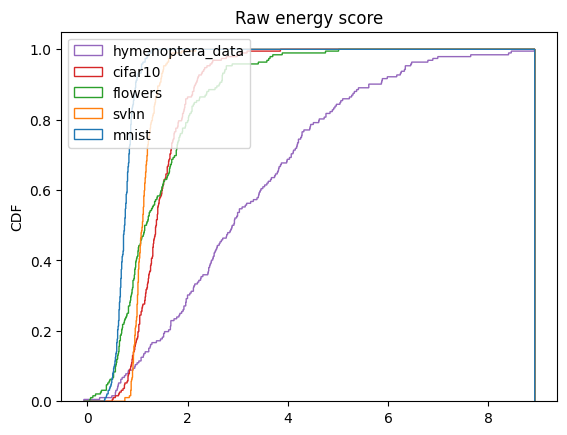

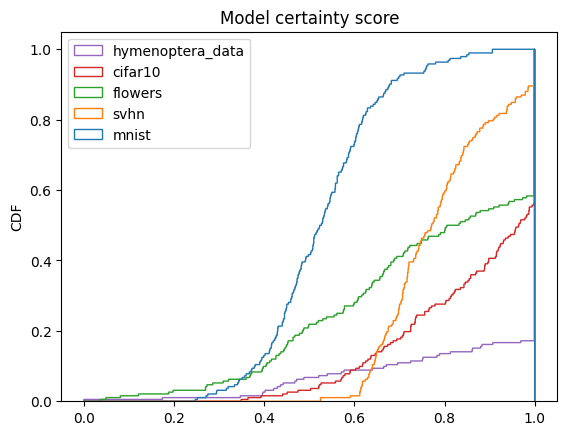

In [3]:
res_to_plot_energy = []
res_to_plot_ood = []
for data_name in list_of_dataset:
    res_to_plot_energy.append(energy_score_list[data_name])
    res_to_plot_ood.append(ood_score_list[data_name])

fig1 = plt.figure()
plt.hist(res_to_plot_energy, bins=1000, cumulative=True, histtype='step', density=True, label=list_of_dataset)
plt.ylabel('CDF')
# plt.hist(res_to_plot_energy, bins=1000, histtype='step', density=True, label=list_of_dataset)
plt.legend(loc='upper left')
plt.title('Raw energy score')

fig2 = plt.figure()
plt.hist(res_to_plot_ood, bins=1000, cumulative=True, histtype='step', density=True, label=list_of_dataset)
plt.ylabel('CDF')
# plt.hist(res_to_plot_ood, bins=1000, histtype='step', density=True, label=list_of_dataset)
plt.legend(loc='upper left')
plt.title('Model certainty score')


# Plot individual images and OOD scores

In [1]:
for i in list_of_dataset:
    fig = plt.figure(dpi=1280)
    rows, columns = 16, 12
    index_map = np.argsort(ood_score_list[i])
    for j in range(len(inputs_list[i])):
        fig.add_subplot(rows,columns, j+1)
        plt.axis('off')
        plt.title(str(ood_score_list[i][index_map[j]]), fontsize=1, y=0.6)
        plt.imshow(inputs_list[i][index_map[j]].permute(1,2,0).numpy())